In [1]:
import seaborn as sns
import folium
from geopandas import GeoSeries, GeoDataFrame


from utils.downloads import (
    Censo,
    Nivel,
    download_malha
)

In [2]:
sns.set_theme(rc={'figure.figsize':(11.7,8.27)})

# Compatibilização dos setores censitários de 2010 e 2022

Com a divulgação do Censo de 2022, precisamos avaliar e compatibilizar os dados a nível de setor censitário entre este e sua última edição, de 2010.

Para essa avaliação precisaremos, primeiramente, baixar os dados georrefenciados de cada um dos censos.

## Distritos

### Download dos dados

In [3]:
distritos10 = download_malha(Censo.CENSO_2010, Nivel.DISTRITOS)
distritos10 = distritos10[distritos10['CD_GEOCODD'].str.startswith('3550308')]
distritos10.sample(3)

,ID,CD_GEOCODD,NM_DISTRIT,geometry
925,4554,355030896,LAJEADO,"POLYGON ((-46.42984 -23.52039, -46.42971 -23.5..."
855,4484,355030826,CONSOLAÇÃO,"POLYGON ((-46.66452 -23.54104, -46.66408 -23.5..."
835,4464,355030806,BARRA FUNDA,"POLYGON ((-46.68784 -23.52145, -46.68790 -23.5..."


In [4]:
distritos22 = download_malha(Censo.CENSO_2022, Nivel.DISTRITOS, filtro='CD_MUN == "3550308"')
distritos22.sample(3)

,CD_REGIAO,NM_REGIAO,CD_UF,NM_UF,CD_MUN,NM_MUN,CD_DIST,NM_DIST,T_SETORES,v0001,v0002,v0003,v0004,v0005,v0006,v0007,geometry
874,3,Sudeste,35,São Paulo,3550308,São Paulo,355030844,Jardim Helena,260,129409,48496,48493,3,2.924680,18.669470,44238,"POLYGON ((-46.39487 -23.49232, -46.39482 -23.4..."
834,3,Sudeste,35,São Paulo,3550308,São Paulo,355030804,Aricanduva,162,89574,37225,37218,7,2.773143,15.178544,32289,"POLYGON ((-46.51779 -23.58627, -46.51736 -23.5..."
877,3,Sudeste,35,São Paulo,3550308,São Paulo,355030847,José Bonifácio,264,128243,51462,51455,7,2.805480,18.854504,45692,"POLYGON ((-46.41706 -23.57735, -46.41708 -23.5..."


Agora, vamos conferir e compatibilizar o sistema de referências dos dois datasets.

In [5]:
distritos10.crs

<Geographic 2D CRS: EPSG:4674>
Name: SIRGAS 2000
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: Latin America - Central America and South America - onshore and offshore. Brazil - onshore and offshore.
- bounds: (-122.19, -59.87, -25.28, 32.72)
Datum: Sistema de Referencia Geocentrico para las AmericaS 2000
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [6]:
distritos22.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Diferente do esperado, os datasets possuem realmente sistemas de referência distintos. Vamos transpor o dataset do Censo 2022 para o mesmo sistema do Censo 2010.

In [7]:
distritos22 = distritos22.to_crs(epsg=4674)

Agora, checamos duplicidade e a quantidade de registros em cada dataset.

In [8]:
distritos10.shape

(96, 4)

In [9]:
distritos10['NM_DISTRIT'].duplicated().any()

False

In [10]:
distritos10['CD_GEOCODD'].duplicated().any()

False

In [11]:
distritos22.shape

(96, 17)

In [12]:
distritos22['NM_DIST'].duplicated().any()

False

In [13]:
distritos22['CD_DIST'].duplicated().any()

False

E checamos os tipos das colunas, em especial as colunas utilizadas como chave (`CD_GEOCODD` e `CD_DIST`) 

In [14]:
distritos10.dtypes

ID               int64
CD_GEOCODD      object
NM_DISTRIT      object
geometry      geometry
dtype: object

In [15]:
distritos22.dtypes

CD_REGIAO      object
NM_REGIAO      object
CD_UF          object
NM_UF          object
CD_MUN         object
NM_MUN         object
CD_DIST        object
NM_DIST        object
T_SETORES      object
v0001          object
v0002          object
v0003          object
v0004          object
v0005          object
v0006          object
v0007          object
geometry     geometry
dtype: object

### Cruzar codigos distritos

Avaliamos agora se os códigos se mantiveram iguais entre os dois censos.

In [16]:
distritos22['CD_DIST'].dtype

dtype('O')

In [17]:
distritos10['CD_GEOCODD'].dtype

dtype('O')

In [18]:
distritos22['CD_DIST'].str.len().unique()

array([9])

In [19]:
distritos10['CD_GEOCODD'].str.len().unique()

array([9])

In [20]:
set(distritos10['CD_GEOCODD'])-set(distritos22['CD_DIST'])

set()

In [21]:
set(distritos22['CD_DIST'])-set(distritos10['CD_GEOCODD'])

set()

E checamos se os códigos fazem referência ao distrito de mesmo nome.

In [22]:
compara_nomes = distritos22[['CD_DIST', 'NM_DIST']].merge(distritos10[['CD_GEOCODD', 'NM_DISTRIT']], left_on='CD_DIST', right_on='CD_GEOCODD')
compara_nomes

,CD_DIST,NM_DIST,CD_GEOCODD,NM_DISTRIT
0,355030801,Água Rasa,355030801,ÁGUA RASA
1,355030802,Alto de Pinheiros,355030802,ALTO DE PINHEIROS
2,355030803,Anhanguera,355030803,ANHANGUERA
3,355030804,Aricanduva,355030804,ARICANDUVA
4,355030805,Artur Alvim,355030805,ARTUR ALVIM
...,...,...,...,...
91,355030892,Vila Medeiros,355030892,VILA MEDEIROS
92,355030893,Vila Prudente,355030893,VILA PRUDENTE
93,355030894,Vila Sônia,355030894,VILA SÔNIA
94,355030895,São Domingos,355030895,SÃO DOMINGOS


In [23]:
compara_nomes['nomes_iguais'] = compara_nomes['NM_DIST'].str.lower() == compara_nomes['NM_DISTRIT'].str.lower()
compara_nomes

,CD_DIST,NM_DIST,CD_GEOCODD,NM_DISTRIT,nomes_iguais
0,355030801,Água Rasa,355030801,ÁGUA RASA,True
1,355030802,Alto de Pinheiros,355030802,ALTO DE PINHEIROS,True
2,355030803,Anhanguera,355030803,ANHANGUERA,True
3,355030804,Aricanduva,355030804,ARICANDUVA,True
4,355030805,Artur Alvim,355030805,ARTUR ALVIM,True
...,...,...,...,...,...
91,355030892,Vila Medeiros,355030892,VILA MEDEIROS,True
92,355030893,Vila Prudente,355030893,VILA PRUDENTE,True
93,355030894,Vila Sônia,355030894,VILA SÔNIA,True
94,355030895,São Domingos,355030895,SÃO DOMINGOS,True


In [24]:
compara_nomes['nomes_iguais'].all()

True

Todos os códigos de distrito se mantiveram e todos correspondem aos mesmos nomes.

### Recorte

Para checar se os poligonos dos distritos sao idênticos, vamos realizar o recorte de um poligono pelo outro. O resultado deve ser um poligono vazio

In [25]:
distritos10 = distritos10.sort_values(by='CD_GEOCODD')

In [26]:
distritos22 = distritos22.sort_values(by='CD_DIST')

Para melhorar a performance da comparação, vamos alterar o sistema de referência para um sistema projetado.

In [27]:
distritos10 = distritos10.to_crs('EPSG:31983')
distritos22 = distritos22.to_crs('EPSG:31983')

/home/d855395/git/compatibilizacao-setores-censitarios/env/lib/python3.12/site-packages/geopandas/geodataframe.py:2467: UserWarning: `keep_geom_type=True` in overlay resulted in 430 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  return geopandas.overlay(


<Axes: >

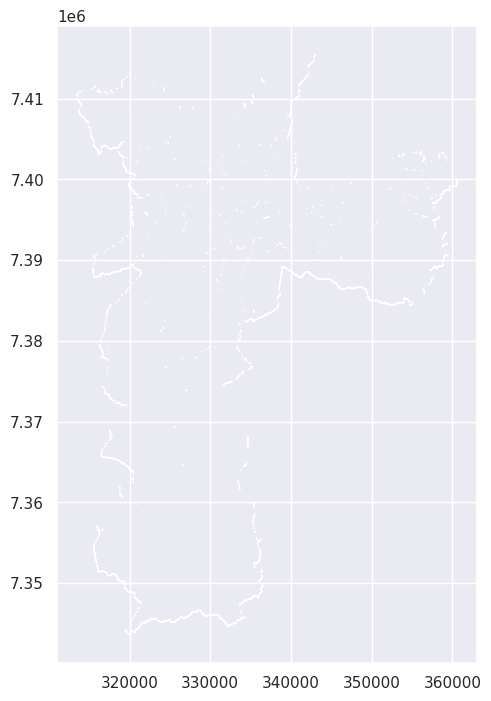

In [28]:
diferenca = distritos10.overlay(distritos22, how='difference')
diferenca.plot()

In [29]:
diferenca.geometry.area.max()

23211.461281901018

In [30]:
diferenca['area'] = diferenca.geometry.area
diferenca = diferenca.sort_values('area', ascending=False)
diferenca

,ID,CD_GEOCODD,NM_DISTRIT,geometry,area
31,4491,355030833,IGUATEMI,"MULTIPOLYGON (((355031.568 7384493.912, 355020...",2.321146e+04
52,4516,355030858,PEDREIRA,"MULTIPOLYGON (((332394.910 7378616.326, 332401...",1.436260e+04
23,4483,355030825,CIDADE TIRADENTES,"MULTIPOLYGON (((357437.586 7387598.403, 357421...",5.125604e+03
33,4494,355030836,ITAIM PAULISTA,"MULTIPOLYGON (((357381.135 7397635.182, 357381...",3.536199e+02
15,4475,355030817,CAMPO LIMPO,"MULTIPOLYGON (((320369.392 7387173.643, 320372...",2.665485e+02
...,...,...,...,...,...
45,4509,355030851,MANDAQUI,"MULTIPOLYGON (((334371.856 7402486.536, 334371...",1.639394e-10
14,4474,355030816,CAMPO GRANDE,"MULTIPOLYGON (((329548.687 7379052.610, 329548...",1.243139e-10
7,4467,355030809,BOM RETIRO,"MULTIPOLYGON (((333961.435 7396024.127, 333961...",2.901178e-11
76,4544,355030886,VILA GUILHERME,"POLYGON ((336941.354 7400522.245, 336941.354 7...",2.023414e-14


Dado que alguns distritos apresentaram diferenças, vamos definir uma tolerância (em metros quadrados) para avaliarmos visualmente.

In [31]:
tolerancia_distritos = 5**2

<Axes: >

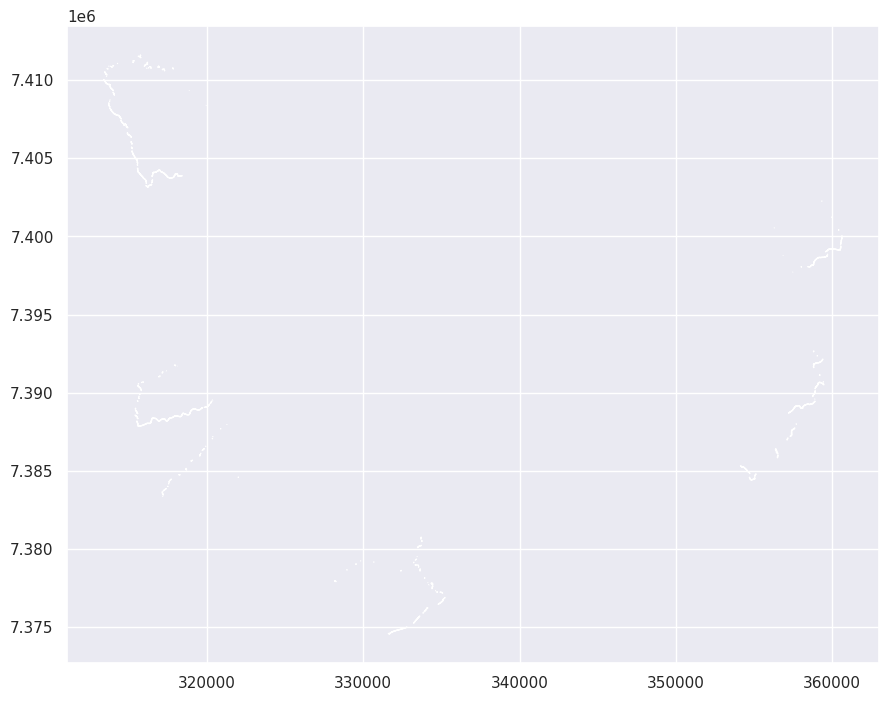

In [32]:
diferenca[diferenca.geometry.area > tolerancia_distritos].plot()

In [33]:
diferenca[diferenca.geometry.area > tolerancia_distritos].shape

(8, 5)

Apenas 8 distritos apresentaram diferenças maiores do que a tolerância atual. Vamos avaliá-los visualmente.

In [34]:
distritos_diferentes = diferenca.loc[diferenca.geometry.area > tolerancia_distritos, 'CD_GEOCODD'].tolist()
distritos_diferentes

['355030833',
 '355030858',
 '355030825',
 '355030836',
 '355030817',
 '355030865',
 '355030803',
 '355030822']

In [35]:
mapa_distritos = distritos10[distritos10['CD_GEOCODD'].isin(distritos_diferentes)].explore(
    name='Distritos (2010)',  # name of the layer in the map
    color='darkred',
)
mapa_distritos = distritos22[distritos22['CD_DIST'].isin(distritos_diferentes)].explore(
    m=mapa_distritos,
    name='Distritos (2022)',  # name of the layer in the map
    color='royalblue',
)
mapa_distritos = diferenca[diferenca['CD_GEOCODD'].isin(distritos_diferentes)].explore(
    m=mapa_distritos,
    name='Diferença',  # name of the layer in the map
    color='purple',
)

folium.LayerControl().add_to(mapa_distritos)  # use folium to add layer control

mapa_distritos

A inspeção visual indica que os distritos se mantiveram os mesmos, com diferenças apenas quanto a ajustes pontuais nos desenhos dos polígonos de distritos de fronteira. Para confirmar, podemos avaliar a interseção entre os distritos para confirmação.

## Proporcionalidade em relação a 2010

In [36]:
def prop(row:GeoSeries, other:GeoSeries|GeoDataFrame, buffer:float=-16) -> GeoDataFrame:
    geom = row['geometry']
    geom = geom.buffer(buffer)
    gdf = other.copy()
    if isinstance(gdf, GeoSeries):
        gdf = GeoDataFrame({'geometry': other.copy()})
        gdf.set_geometry('geometry')
    gdf['geometry'] = gdf.intersection(geom)
    gdf['inter_area'] = gdf['geometry'].area
    gdf['inter_perc'] = gdf['inter_area']/geom.area
    return gdf

In [37]:
distritos_2010 = distritos10['CD_GEOCODD'].to_list()

In [38]:
prop_22to10 = distritos22.copy()
prop_22to10.loc[:,distritos_2010] = prop_22to10.apply(lambda x: prop(x, distritos10['geometry']).inter_perc.to_list(), axis=1)
prop_22to10

,CD_REGIAO,NM_REGIAO,CD_UF,NM_UF,CD_MUN,NM_MUN,CD_DIST,NM_DIST,T_SETORES,v0001,...,355030887,355030888,355030889,355030890,355030891,355030892,355030893,355030894,355030895,355030896
831,3,Sudeste,35,São Paulo,3550308,São Paulo,355030801,Água Rasa,174,85788,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
832,3,Sudeste,35,São Paulo,3550308,São Paulo,355030802,Alto de Pinheiros,134,37359,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
833,3,Sudeste,35,São Paulo,3550308,São Paulo,355030803,Anhanguera,191,75360,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
834,3,Sudeste,35,São Paulo,3550308,São Paulo,355030804,Aricanduva,162,89574,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
835,3,Sudeste,35,São Paulo,3550308,São Paulo,355030805,Artur Alvim,203,95575,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
922,3,Sudeste,35,São Paulo,3550308,São Paulo,355030892,Vila Medeiros,237,114939,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
923,3,Sudeste,35,São Paulo,3550308,São Paulo,355030893,Vila Prudente,208,105690,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
924,3,Sudeste,35,São Paulo,3550308,São Paulo,355030894,Vila Sônia,321,123748,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
925,3,Sudeste,35,São Paulo,3550308,São Paulo,355030895,São Domingos,209,88884,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [39]:
prop_22to10['qtd_inter'] = (prop_22to10[distritos_2010]>0).T.sum()
prop_22to10

,CD_REGIAO,NM_REGIAO,CD_UF,NM_UF,CD_MUN,NM_MUN,CD_DIST,NM_DIST,T_SETORES,v0001,...,355030888,355030889,355030890,355030891,355030892,355030893,355030894,355030895,355030896,qtd_inter
831,3,Sudeste,35,São Paulo,3550308,São Paulo,355030801,Água Rasa,174,85788,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
832,3,Sudeste,35,São Paulo,3550308,São Paulo,355030802,Alto de Pinheiros,134,37359,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
833,3,Sudeste,35,São Paulo,3550308,São Paulo,355030803,Anhanguera,191,75360,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
834,3,Sudeste,35,São Paulo,3550308,São Paulo,355030804,Aricanduva,162,89574,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
835,3,Sudeste,35,São Paulo,3550308,São Paulo,355030805,Artur Alvim,203,95575,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
922,3,Sudeste,35,São Paulo,3550308,São Paulo,355030892,Vila Medeiros,237,114939,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1
923,3,Sudeste,35,São Paulo,3550308,São Paulo,355030893,Vila Prudente,208,105690,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1
924,3,Sudeste,35,São Paulo,3550308,São Paulo,355030894,Vila Sônia,321,123748,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1
925,3,Sudeste,35,São Paulo,3550308,São Paulo,355030895,São Domingos,209,88884,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1


In [40]:
prop_22to10[prop_22to10['qtd_inter']>1]

,CD_REGIAO,NM_REGIAO,CD_UF,NM_UF,CD_MUN,NM_MUN,CD_DIST,NM_DIST,T_SETORES,v0001,...,355030888,355030889,355030890,355030891,355030892,355030893,355030894,355030895,355030896,qtd_inter


In [41]:
sample = prop_22to10.sample(5)
sample

,CD_REGIAO,NM_REGIAO,CD_UF,NM_UF,CD_MUN,NM_MUN,CD_DIST,NM_DIST,T_SETORES,v0001,...,355030888,355030889,355030890,355030891,355030892,355030893,355030894,355030895,355030896,qtd_inter
885,3,Sudeste,35,São Paulo,3550308,São Paulo,355030855,Parelheiros,557,153695,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
847,3,Sudeste,35,São Paulo,3550308,São Paulo,355030817,Campo Limpo,486,236162,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
845,3,Sudeste,35,São Paulo,3550308,São Paulo,355030815,Campo Belo,254,71058,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
887,3,Sudeste,35,São Paulo,3550308,São Paulo,355030857,Parque do Carmo,139,74677,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
911,3,Sudeste,35,São Paulo,3550308,São Paulo,355030881,Tremembé,425,196563,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [42]:
sample = sample.loc[:, (sample != 0).any()]
sample

,CD_REGIAO,NM_REGIAO,CD_UF,NM_UF,CD_MUN,NM_MUN,CD_DIST,NM_DIST,T_SETORES,v0001,...,v0005,v0006,v0007,geometry,355030815,355030817,355030855,355030857,355030881,qtd_inter
885,3,Sudeste,35,São Paulo,3550308,São Paulo,355030855,Parelheiros,557,153695,...,2.968603,10.759432,51183,"POLYGON ((331836.535 7357177.161, 331838.058 7...",0.0,0.0,1.0,0.0,0.0,1
847,3,Sudeste,35,São Paulo,3550308,São Paulo,355030817,Campo Limpo,486,236162,...,2.698311,7.645970,87484,"POLYGON ((320314.744 7386993.428, 320312.677 7...",0.0,1.0,0.0,0.0,0.0,1
845,3,Sudeste,35,São Paulo,3550308,São Paulo,355030815,Campo Belo,254,71058,...,2.309907,12.891838,30593,"POLYGON ((329439.691 7384123.427, 329454.357 7...",1.0,0.0,0.0,0.0,0.0,1
887,3,Sudeste,35,São Paulo,3550308,São Paulo,355030857,Parque do Carmo,139,74677,...,2.827611,17.531653,26301,"POLYGON ((352617.255 7390144.533, 352622.865 7...",0.0,0.0,0.0,1.0,0.0,1
911,3,Sudeste,35,São Paulo,3550308,São Paulo,355030881,Tremembé,425,196563,...,2.861127,17.903198,68552,"POLYGON ((338977.390 7414197.122, 338976.439 7...",0.0,0.0,0.0,0.0,1.0,1


In [43]:
sample10 = [d for d in distritos_2010 if d in sample.columns]

In [44]:
mapa_inter = distritos10[distritos10['CD_GEOCODD'].isin(sample10)].explore(
    name='Distritos (2010)',  # name of the layer in the map
    color='darkred',
)
mapa_inter = sample.explore(
    m=mapa_inter,
    name='Distritos (2022)',  # name of the layer in the map
    color='royalblue',
)

folium.LayerControl().add_to(mapa_inter)  # use folium to add layer control

mapa_inter

## Setores censitários